In [1]:
import gpflow as gpf
import numpy as np
import gpflow.multioutput.kernels as mk
import gpflow.multioutput.features as mf
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from time import time
import tensorflow as tf
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import os
from link_bot_notebooks import experiments_util
from link_bot_gaussian_process.link_bot_gp import LinkBotGP
from link_bot_gaussian_process import data_reformatting, error_metrics
from tabulate import tabulate
tf.logging.set_verbosity(tf.logging.FATAL)
np.set_printoptions(suppress=True, precision=4, linewidth=200)

In [2]:
plt.style.use("slides")
plt.style.use("slides")

In [3]:
data = np.load("240_50_random4.npz")
train_idx_start = 0
train_idx_end = 200
test_idx_start = 200
test_idx_end = 240

fwd_train_data = data_reformatting.format_forward_data(data, train_idx_start, train_idx_end)
fwd_train_x_flat, fwd_train_y, fwd_train_u_flat, fwd_train_x, fwd_train_x_trajs, fwd_train_u_trajs = fwd_train_data
fwd_test_data = data_reformatting.format_forward_data(data, test_idx_start, test_idx_end)
fwd_test_x_flat, fwd_test_y, fwd_test_u_flat, fwd_test_x, fwd_test_x_trajs, fwd_test_u_trajs = fwd_test_data

inv_train_data = data_reformatting.format_inverse_data(data, train_idx_start, train_idx_end, take_every=10)
inv_train_x = inv_train_data[0]
inv_train_y = inv_train_data[1]
inv_test_data = data_reformatting.format_inverse_data(data, test_idx_start, test_idx_end, take_every=10)
inv_test_x = inv_test_data[0]
inv_test_y = inv_test_data[1]

In [4]:
config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=False, per_process_gpu_memory_fraction=0.1))
gpf.reset_default_session(config=config)
fwd_model = LinkBotGP()
inv_model = LinkBotGP()

fwd_model.train(fwd_train_x, fwd_train_y, maximum_training_iterations=300, n_inducing_points=20)
inv_model.train(inv_train_x, inv_train_y, maximum_training_iterations=300, n_inducing_points=20)

training time: 9.48365831375122s
training time: 5.841100454330444s


In [5]:
log_path = experiments_util.experiment_name('separate_independent', 'gpf')
fwd_model.save(log_path, 'fwd_model')
inv_model.save(log_path, 'inv_model')

Saving model to /home/pmitrano/catkin_ws/src/link_bot/link_bot_gaussian_process/notebooks/log_data/separate_independent/May_31_11-33-06__82ccf8f49a__gpf/fwd_model
Saving model to /home/pmitrano/catkin_ws/src/link_bot/link_bot_gaussian_process/notebooks/log_data/separate_independent/May_31_11-33-06__82ccf8f49a__gpf/inv_model


In [6]:
headers = ['error metric', 'min', 'max', 'mean', 'median', 'std']
aggregate_metrics = np.vstack((error_metrics.fwd_model_error_metrics(fwd_model, fwd_test_x, fwd_test_y),
                               error_metrics.inv_model_error_metrics(inv_model, inv_test_x, inv_test_y)))
table = tabulate(aggregate_metrics, headers=headers, tablefmt='github', floatfmt='6.3f')
print(table)

| error metric             |    min |    max |   mean |   median |    std |
|--------------------------|--------|--------|--------|----------|--------|
| tail position error (m)  |  0.000 |  0.085 |  0.019 |    0.013 |  0.017 |
| mid position error (m)   |  0.000 |  0.092 |  0.014 |    0.009 |  0.015 |
| head position error (m)  |  0.000 |  0.056 |  0.005 |    0.005 |  0.003 |
| total position error (m) |  0.004 |  0.156 |  0.039 |    0.028 |  0.028 |
| speed (m/s)              |  0.000 |  0.106 |  0.037 |    0.036 |  0.024 |
| angle (deg)              |  0.004 | 50.501 | 12.051 |    6.582 | 12.115 |


In [7]:
untrained_A = np.zeros(2)
untrained_B = np.eye(2)

trained_A = np.array([[0.005394, -0.002816], [0.001254, -0.00443]])
trained_B = np.array([[0.366756,  0.017419], [0.023738, 0.378886]])

# FIXME: This are probabily wrong now
def predict_linear_model(A, B, x_traj, u_traj):
    dt = 0.1
    initial_x = x_traj[0][0:2]  # select just the tail
    xs = np.ndarray((u_traj.shape[0], 2))
    xs[0] = initial_x
    x = initial_x
    for i, u in enumerate(u_traj):
        x = x + dt*A@x + dt*B@u
        xs[i] = x
    return xs

def one_step_predict_linear_model(A, B, x_traj, u_traj):
    dt = 0.1
    xs = np.ndarray((u_traj.shape[0], 2))
    xs[0] = x_traj[0][0:2]
    for i in range(u_traj.shape[0] - 1):
        u = u_traj[i]
        x = x_traj[i][0:2]
        x_next = x + dt*A@x + dt*B@u
        xs[i+1] = x_next
    return xs

def batch_one_step_predict_linear_model(A, B, batch_x_traj, batch_u_traj):
    n_traj, n_step, _  = batch_x_traj.shape
    xs = np.ndarray((n_traj, n_step, 2))
    for i, (x_traj, u_traj) in enumerate(zip(batch_x_traj, batch_u_traj)):
        xs[i] = one_step_predict_linear_model(A, B, x_traj, u_traj)
    return xs

In [8]:
total_displacement = np.linalg.norm(fwd_test_y[:, 0:2], axis=1) + np.linalg.norm(fwd_test_y[:, 2:4], axis=1) + np.linalg.norm(fwd_test_y[:, 4:6], axis=1)
print("Some stats about the testing data:")
print('min displacement in test', np.min(total_displacement))
print('max displacement in test', np.max(total_displacement))
print('mean displacement in test', np.mean(total_displacement))

Some stats about the testing data:
min displacement in test 0.0010301430513861287
max displacement in test 0.30061229261431177
mean displacement in test 0.11060115018261645


In [9]:
# error for linear models
untrained_linear_data = batch_one_step_predict_linear_model(untrained_A, untrained_B, fwd_test_x_trajs, fwd_test_u_trajs)
trained_linear_data = batch_one_step_predict_linear_model(trained_A, trained_B, fwd_test_x_trajs, fwd_test_u_trajs)

untrained_linear_tail_error = np.linalg.norm(untrained_linear_data - fwd_test_x_trajs[:, :, :2], axis=2)
trained_linear_tail_error = np.linalg.norm(trained_linear_data - fwd_test_x_trajs[:, :, :2], axis=2)
print("Stats about the old linear models:")
print("untrained linear model tail position error (min/max/mean/median)", untrained_linear_tail_error.min(), untrained_linear_tail_error.max(), untrained_linear_tail_error.mean(), np.median(untrained_linear_tail_error), np.std(untrained_linear_tail_error))
print("trained linear model tail position error (min/max/mean/median)", trained_linear_tail_error.min(), trained_linear_tail_error.max(), trained_linear_tail_error.mean(), np.median(trained_linear_tail_error), np.std(trained_linear_tail_error))
print(np.unravel_index(untrained_linear_tail_error.argmax(), untrained_linear_tail_error.shape))

Stats about the old linear models:
untrained linear model tail position error (min/max/mean/median) 0.0 0.13397974311901784 0.0385919179098155 0.02953505630643889 0.026694152438682964
trained linear model tail position error (min/max/mean/median) 0.0 0.08858213733771024 0.023924307098635942 0.022060135471624727 0.01697465033568904
(22, 31)


In [29]:
def predict(fwd_model, traj, steps=1, initial_variance = 0.00001):
    test_x_traj, test_u_traj  = traj
    traj_length = test_x_traj.shape[0]
    
    assert steps < traj_length, "steps {} > traj length {}!".format(steps, traj_length)
    
    if test_x_traj.shape[0] > test_u_traj.shape[0]:
        test_x_traj = test_x_traj[:test_u_traj.shape[0]]
        
    mu_combined_test_x = np.hstack((test_x_traj, test_u_traj))
        
    # define the initial distribution
    mu_combined_test_x_t = mu_combined_test_x[0]
    sigma_combined_test_x = np.eye(fwd_model.n_inputs) * initial_variance
    # assume no control variance
    sigma_combined_test_x[-2, -2] = 0
    sigma_combined_test_x[-1, -1] = 0
    
    # sample from that initial distribution to get initial particles to feed into the GP
    num_particles = 50
    combined_x_t_particles = np.random.multivariate_normal(mu_combined_test_x_t, sigma_combined_test_x, num_particles)
    particles = np.zeros((steps, num_particles, fwd_model.n_inputs))
    
    for t in range(steps):
        particles[t] = combined_x_t_particles
        combined_x_t_particles_relative = data_reformatting.make_relative_to_head(combined_x_t_particles)
        mu_delta_x_t_plus_1s, var_delta_x_t_plus_1s = fwd_model.model.predict_y(combined_x_t_particles_relative)
        # sample point from the gaussian prediction
        combined_x_t_plus_1_particles = np.empty_like(combined_x_t_particles)
        for j, (mu_delta_x_t_plus_1_j, var_delta_x_t_plus_1_j) in enumerate(zip(mu_delta_x_t_plus_1s, var_delta_x_t_plus_1s)):
            # We assumed that the GPs are independant for each output dimension, so the full covariance matrix is diagonal
            sigma_delta_x_t_plus_1_j = np.diag(var_delta_x_t_plus_1_j)
            u_t_plus_1_j = test_u_traj[t + 1]
            delta_delta_x_t_j = np.random.multivariate_normal(mu_delta_x_t_plus_1_j, sigma_delta_x_t_plus_1_j)
            # predict only gives the delta position, so we have to integrate here
            delta_delta_combined_x_t_j = np.hstack((delta_delta_x_t_j, [0, 0]))
            combined_x_t_plus_1_particles[j] =  combined_x_t_particles[j] + delta_delta_combined_x_t_j
        
        combined_x_t_particles = combined_x_t_plus_1_particles
            
    return particles, test_x_traj, test_u_traj

In [30]:
def predict_no_ground_truth(my_model, initial_x, u, steps=1, initial_variance = 0.00001):
    # define the initial distribution
    mu_combined_x_t =  np.hstack((initial_x, u))
    sigma_combined_x_t = np.eye(my_model.n_inputs) * initial_variance
    # assume no control variance
    sigma_combined_x_t[-2, -2] = 0
    sigma_combined_x_t[-1, -1] = 0
    
    # sample from that initial distribution to get initial particles to feed into the GP
    num_particles = 50
    combined_x_t_particles = np.random.multivariate_normal(mu_combined_x_t, sigma_combined_x_t, num_particles)
    particles = np.zeros((steps, num_particles, my_model.n_inputs))
    
    x_traj = np.reshape(initial_x, [1, -1])
    u_traj = np.ones((steps, 2))*u
    trained_linear_data = predict_linear_model(trained_A, trained_B, x_traj, u_traj)

    for t in range(steps):
        particles[t] = combined_x_t_particles
        combined_x_t_particles_relative = data_reformatting.make_relative_to_head(combined_x_t_particles)
        mu_delta_x_t_plus_1s, var_delta_x_t_plus_1s = fwd_model.model.predict_y(combined_x_t_particles_relative)
        # sample point from the gaussian prediction
        combined_x_t_plus_1_particles = np.empty_like(combined_x_t_particles)
        for j, (mu_delta_x_t_plus_1_j, var_delta_x_t_plus_1_j) in enumerate(zip(mu_delta_x_t_plus_1s, var_delta_x_t_plus_1s)):
            # We assumed that the GPs are independant for each output dimension, so the full covariance matrix is diagonal
            sigma_delta_x_t_plus_1_j = np.diag(var_delta_x_t_plus_1_j)
            delta_delta_x_t_j = np.random.multivariate_normal(mu_delta_x_t_plus_1_j, sigma_delta_x_t_plus_1_j)
            # predict only gives the delta position, so we have to integrate here
            delta_delta_combined_x_t_j = np.hstack((delta_delta_x_t_j, [0, 0]))
            combined_x_t_plus_1_particles[j] =  combined_x_t_particles[j] + delta_delta_combined_x_t_j
        
        combined_x_t_particles = combined_x_t_plus_1_particles
            
    return particles, trained_linear_data

In [31]:
%matplotlib inline 

def plot_predict(particles, test_x_traj=None, test_u_traj=None, untrained_linear_data=None, trained_linear_data=None):
    T = particles.shape[0]
    if test_x_traj is not None:
        x0s = [test_x_traj[0, 0], test_x_traj[0, 2], test_x_traj[0, 4]]
        y0s = [test_x_traj[0, 1], test_x_traj[0, 3], test_x_traj[0, 5]]
    
    fig = plt.figure(figsize=(10,10))
    
    x_t_particles_data = []
    for x_t_particle in particles[0]:
        x_t_particles_xs = [x_t_particle[0], x_t_particle[2], x_t_particle[4]]
        x_t_particles_ys = [x_t_particle[1], x_t_particle[3], x_t_particle[5]]
        line = plt.plot(x_t_particles_xs, x_t_particles_ys, color='black', alpha=0.2)[0]
        x_t_particles_data.append(line)
            
    if test_x_traj is not None:
        plt.plot(x0s, y0s, color='orange')
        
    x_next_data = []
    if test_x_traj is not None:
        x_t_plus_1 = test_x_traj[1]
        xs_next = [x_t_plus_1[0], x_t_plus_1[2], x_t_plus_1[4]]
        ys_next = [x_t_plus_1[1], x_t_plus_1[3], x_t_plus_1[5]]
        x_next_data = plt.plot(xs_next, ys_next, color='blue')[0]
        
    untrained_linear_x_next_data = []
    if untrained_linear_data is not None:
        untrained_linear_x_t_plus_1 = untrained_linear_data[1]
        untrained_linear_x_next_data = plt.scatter(untrained_linear_x_t_plus_1[0], untrained_linear_x_t_plus_1[1], color='r')
    trained_linear_x_next_data = []
    if trained_linear_data is not None:
        trained_linear_x_t_plus_1 = trained_linear_data[1]
        trained_linear_x_next_data = plt.scatter(trained_linear_x_t_plus_1[0], trained_linear_x_t_plus_1[1], color='g')

    if test_x_traj is not None:
        plt.quiver(test_x_traj[0, 4], test_x_traj[0, 5], test_u_traj[0, 0], test_u_traj[0, 1], color='black', width=0.004)

    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.xlim([-7,7])
    plt.ylim([-7,7])
    custom_lines = [Line2D([0], [0], color='black', lw=1, alpha=0.1),
                    Line2D([0], [0], color='orange', lw=1),
                    Line2D([0], [0], color='blue', lw=1),
                    Line2D([0], [0], color='red', lw=1),
                    Line2D([0], [0], color='green', lw=1),
                   ]

    l = plt.legend(custom_lines, ['predictions', r'$x_0$', r'$x_t$', 'linear (init)', 'linear (fine-tuned)'])
    
    def update(t):
        x_t_particles = particles[t]
        for x_t_particle_d, x_t_particle in zip(x_t_particles_data, x_t_particles):
            x_t_particles_xs = [x_t_particle[0], x_t_particle[2], x_t_particle[4]]
            x_t_particles_ys = [x_t_particle[1], x_t_particle[3], x_t_particle[5]]
            x_t_particle_d.set_xdata(x_t_particles_xs)
            x_t_particle_d.set_ydata(x_t_particles_ys)
            
        if untrained_linear_data is not None:
            untrained_linear_x_t_plus_1 = untrained_linear_data[t]
            untrained_linear_x_next_data.set_offsets([untrained_linear_x_t_plus_1[0],  untrained_linear_x_t_plus_1[1]])
        if untrained_linear_data is not None:
            trained_linear_x_t_plus_1 = trained_linear_data[t]
            trained_linear_x_next_data.set_offsets([trained_linear_x_t_plus_1[0],  trained_linear_x_t_plus_1[1]])
        
        if test_x_traj is not None:
            x_t_plus_1 = test_x_traj[t]
            xs_next = [x_t_plus_1[0], x_t_plus_1[2], x_t_plus_1[4]]
            ys_next = [x_t_plus_1[1], x_t_plus_1[3], x_t_plus_1[5]]
            x_next_data.set_xdata(xs_next)
            x_next_data.set_ydata(ys_next)
        ax = fig.gca()
        ax.relim()
        ax.autoscale_view()

    
    anim = FuncAnimation(fig, update, frames=np.arange(0, T), interval=100)
    plt.close()
    return anim

In [32]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

In [ ]:
np.random.seed(1)
# 1, 9 and 13 are interesting
# 8 and 22 are the worst cases for the old linear models
# 14 is accurate
# 3 is really bad
trajectory_idx =  4
traj = fwd_test_x_trajs[trajectory_idx], fwd_test_u_trajs[trajectory_idx]
particles, fwd_test_x_traj, fwd_test_u_traj = predict(fwd_model, traj, steps=49)
untrained_linear_data = predict_linear_model(untrained_A, untrained_B, fwd_test_x_trajs[trajectory_idx], fwd_test_u_trajs[trajectory_idx])
trained_linear_data = predict_linear_model(trained_A, trained_B, fwd_test_x_trajs[trajectory_idx], fwd_test_u_trajs[trajectory_idx])
anim = plot_predict(particles, fwd_test_x_traj, fwd_test_u_traj, untrained_linear_data, trained_linear_data)
anim_html = anim.to_jshtml()
anim.save('test_ex_{}.gif'.format(trajectory_idx), writer='imagemagick', fps=20)
HTML(anim.to_jshtml())

In [37]:
initial_x = np.array([-1, 0, 0, 0, 1, 0]) + np.random.randn(6)*1e-3
u = np.array([-0.1, -0.5])
# initial_x = fwd_test_x_trajs[23, 0]
# u = fwd_test_u_trajs[23, 0]
particles, linear_data = predict_no_ground_truth(fwd_model, initial_x, u, steps=70)
anim = plot_predict(particles, trained_linear_data=linear_data)
HTML(anim.to_jshtml())

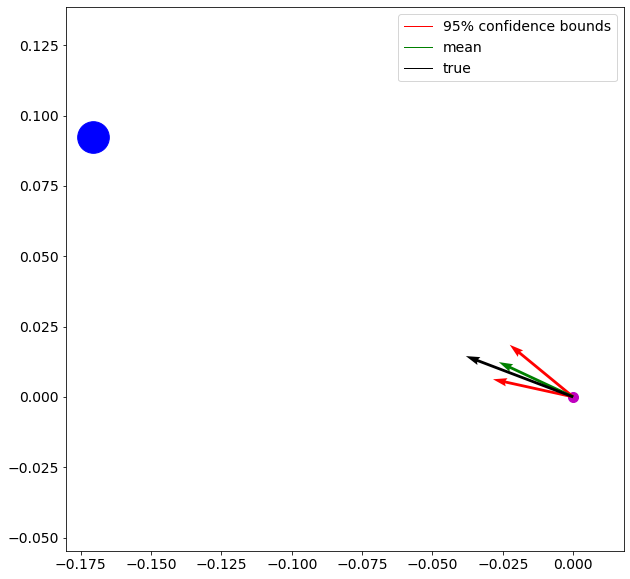

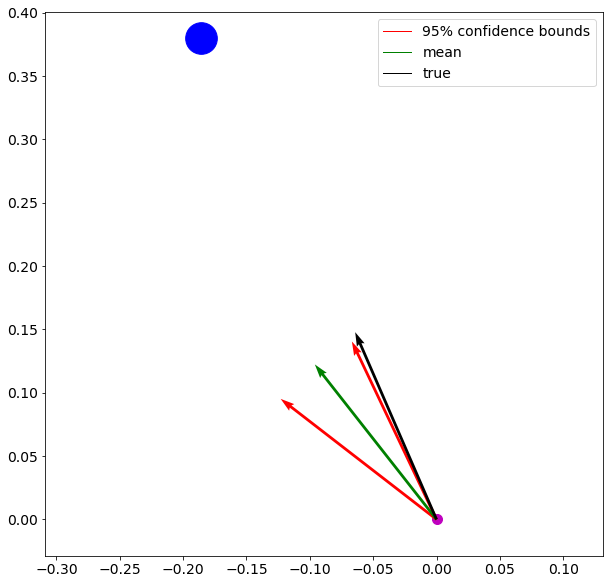

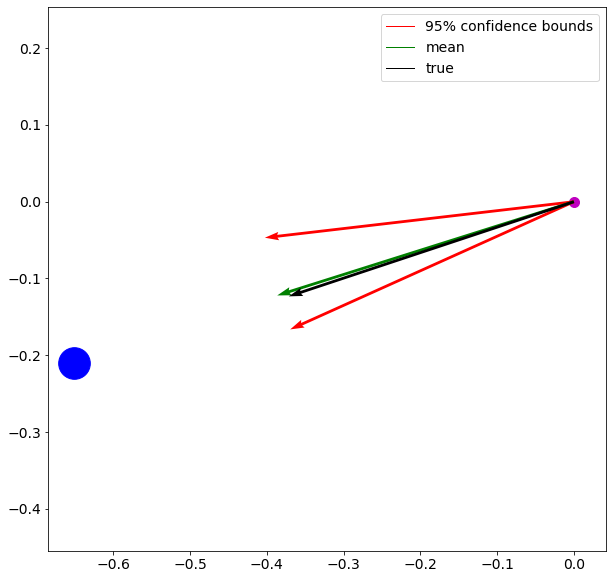

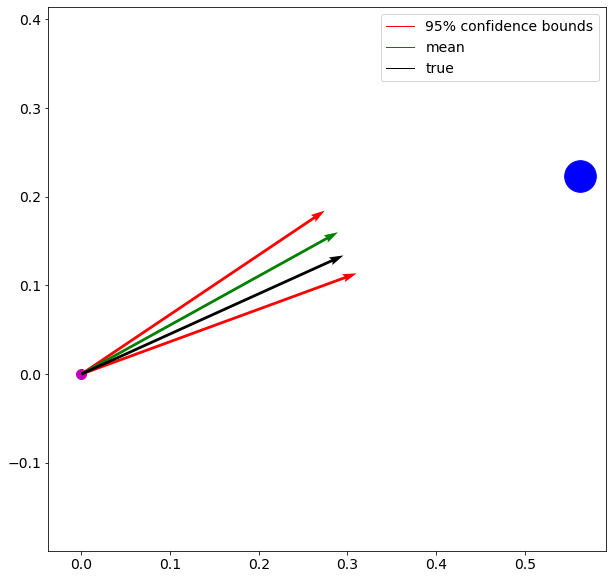

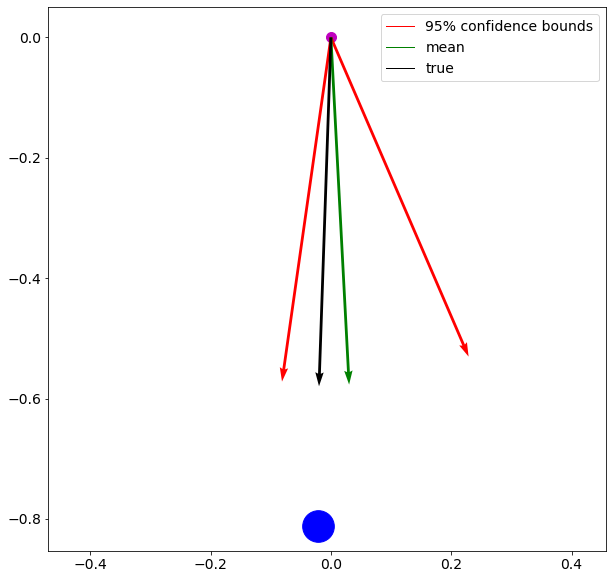

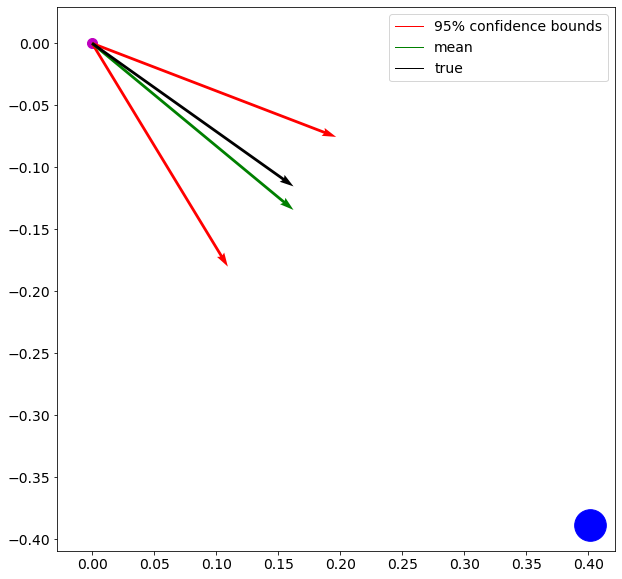

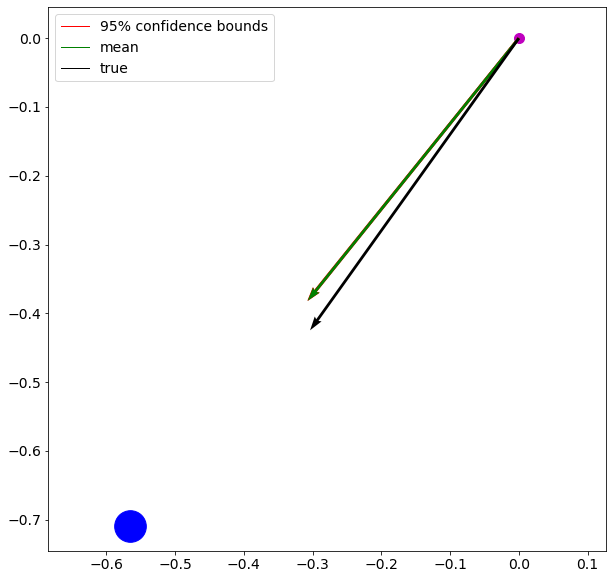

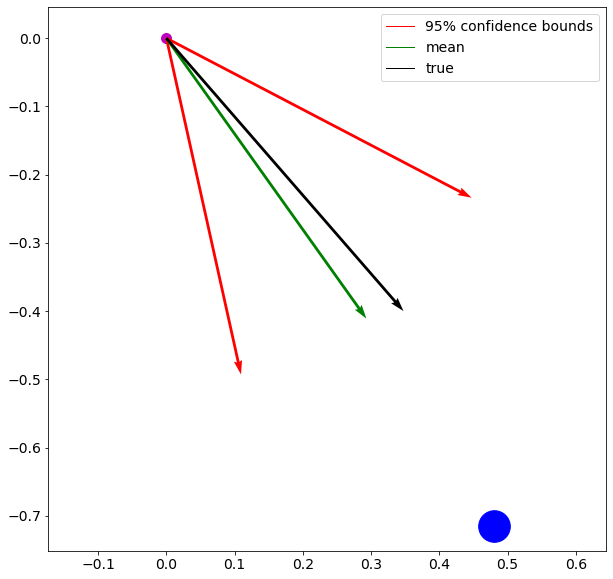

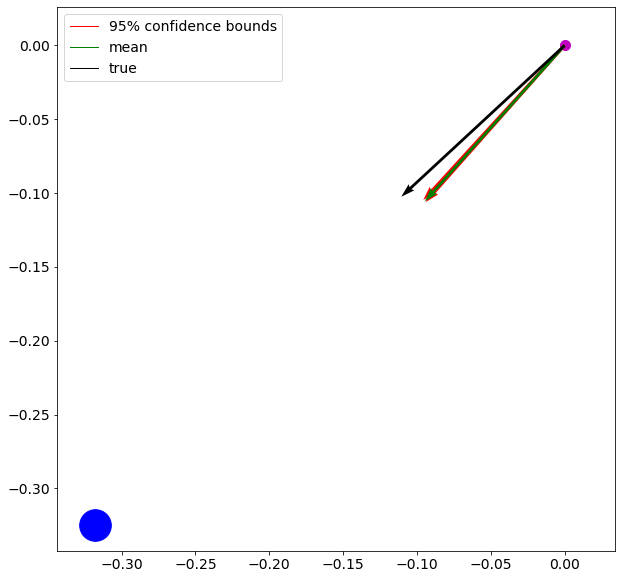

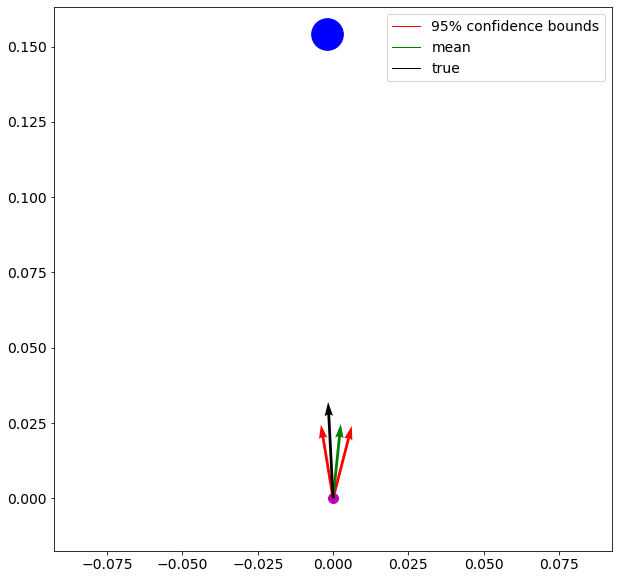

In [16]:
def plot_inv_prediction(inv_x, inv_y):
    inv_x = np.expand_dims(inv_x, axis=0)
    mu, sig = inv_model.model.predict_y(inv_x)
    s1 = np.array([[0, 0, 0, 0, 0, 0]])
    s2 = s1 + inv_x

    plt.figure(figsize=(10,10))
    plt.scatter(0, 0, color='m', s=100)
    plt.scatter(s2[0,4], s2[0,5], color='b', s=1000)
    mu_cos = mu[0, 0]
    lower_bound_cos = mu_cos - 1.96 * sig[0, 0]
    upper_bound_cos = mu_cos + 1.96 * sig[0, 0]
    mu_sin = mu[0, 1]
    lower_bound_sin = mu_sin - 1.96 * sig[0, 1]
    upper_bound_sin = mu_sin + 1.96 * sig[0, 1]
    mu_mag = mu[0, 2]
    mu_nu = np.linalg.norm(mu[0, :2])
    lower_bound_nu = np.hypot(lower_bound_cos, lower_bound_sin)
    upper_bound_nu = np.hypot(upper_bound_cos, upper_bound_sin)
    plt.quiver([s1[0,4], s1[0,4], s1[0,4], s1[0,4]],
               [s1[0,5], s1[0,5], s1[0,5], s1[0,5]],
               [lower_bound_cos / lower_bound_nu * mu_mag, upper_bound_cos / upper_bound_nu * mu_mag, mu_cos / mu_nu * mu_mag, inv_y[0] * inv_y[2]],
               [lower_bound_sin / lower_bound_nu * mu_mag, upper_bound_sin / upper_bound_nu * mu_mag, mu_sin / mu_nu * mu_mag, inv_y[1] * inv_y[2]],
               color=['r', 'r', 'g', 'k'],
               width=0.005,
               scale=1.5,
              )
    plt.axis("equal")
    custom_lines = [Line2D([0], [0], color='red', lw=1),
                    Line2D([0], [0], color='green', lw=1),
                    Line2D([0], [0], color='black', lw=1),
                   ]

    l = plt.legend(custom_lines, ['95% confidence bounds', 'mean', 'true'])
    
for i in range(10):
    test_idx = 50 * i
    plot_inv_prediction(inv_test_x[test_idx], inv_test_y[test_idx])

In [17]:
mu, sig = inv_model.model.predict_y(test_inverse_combined_x)
print(np.min(mu, axis=0))

NameError: name 'test_inverse_combined_x' is not defined

# Profiling the GP prediction

In [ ]:
%%timeit
x_star = np.random.randn(1,8)
fwd_model.model.predict_y(x_star)

In [ ]:
%%timeit
x_star = np.random.randn(1,6)
inv_model.model.predict_y(x_star)